# Creative FLIP collab session at MILL

The following are example analysis using the Europeana API. These can serve as a starting point for testing out ideas or creating new analysis.

## Memory Issues

When running this notebook in mybinder.org we can run into memory issues because of all the data we are downloading and processing and the fact that that mybinder.org only provieds 2 GBs of RAM per instance. 

We have added code to delete query results and run the garbage collector after each example. Feel free to skip running the cleanu code in case you want to reatry some examples, just be mindfull of your memory usage, else you might crash your notebook. Memory usage is visible at the bottom of the notebook window.

## Setup Europeana client

The following code sets up the Europeana API client. You need to run it at least onece before running the examples below.

In [ ]:
# Import required libraries
import collections
import gc
import os
from typing import List

import matplotlib.pyplot as plt
from dotenv import load_dotenv
from europeana import (
    EuropeanaClient,
    AggregateField,
    SearchField,
    MediaType,
    Profile,
    Reusability,
)


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Load environment variables
load_dotenv()

# Get API key
api_key = os.getenv("EUROPEANA_API_KEY")
# api_key = None
if not api_key:
    # If no environment variable is set, you can enter your API key directly here
    api_key = input("Enter your Europeana API key: ")

print(f"API key loaded: {'Yes' if api_key else 'No'}")

client = EuropeanaClient(api_key)

## Example 1: Gap in data - Place but no location

Here we give an example of analysing the dataset with regards to gaps in the data. Items in the Europeana database have an atribute named `dcterms:spatial` defined as the following

```
Information about the spatial characteristics of the original analog or born digital object (e.g. a named place, location, coordinates, or administrative entity)
```

Items also have other atributes that also describe their spatial characteristics, e.g. `pl_wgs84_pos_lat` and `pl_wgs84_pos_long` describing latitude and longitude of the item for a more precise location. We want to see what portions of items have `dcterms:spatial` but are missing the other spatial atributes resulting in incomplete spatial data for the item.

For this example we will look at items of `MediaType.IMAGE` by `Rembrandt`.

First we cunstruct our query and execute the search

In [ ]:
query_ex_1 = client.query().who("Rembrandt").media_type(MediaType.IMAGE)
result_ex_1 = list(client.search_all(query_ex_1, max_records=10000))

Now we can do the comparison for each item in our results. Lets start by looking at if dcterms:spatial exist wether latidue and longitude exists also

In [ ]:
items_missing_lat_long = 0

for item in result_ex_1:
    if item.dcterms_spatial and (
        not item.edm_place_latitude or not item.edm_place_longitude
    ):
        items_missing_lat_long += 1

print(f"Total items: {len(result_ex_1)}")
print(
    f"Items with dcterms:spatial but missing latitude/longitude: {items_missing_lat_long}"
)
print(f"Percentage: {items_missing_lat_long / len(result_ex_1) * 100:.2f}%")

Now we see that there exist some amount of items that have a spatial description but still don't have precice latitude or longitude.

But what kind of information is actually encoded in `dcterms:spatial`? Maybe we have access to latitude and longitute there? Lets have a look

In [ ]:
for item in result_ex_1[
    :50:5
]:  # Print every 5th item of the first 50 items to limit output
    print(item.dcterms_spatial)

Now we see some interesting things. `dcterms:spatial` can include more than one entry and many of the entries are links to external resources. Some of these links describe large areas (e.g. Germany) and smaller areas (e.g. Hannover region). Sometimes there is a place name, f.x. `Suomi, Uusimaa, Helsinki, Kaartinkaupunki Helsinki, Pohjoisesplanadi 2`. Some entries link to more precise entities, like [http://data.europeana.eu/organization/4562](http://data.europeana.eu/organization/4562') which links to Statens Museum of Kunst in Copenhagen Denmark.

What we can see here is that `dcterms:spatial` can include a wide range of different formats. This makes working with the data in this field problematic as it is not consistent internally, i.e. is not all of the same type.

In [ ]:
# Free up memory
del result_ex_1
gc.collect()

# Example 2: How much of items are from outside of the EU

Here we want want to try to see what proportion of items have a spatial reference to outside the EU. First we need to compile a list of EU countries as a reference.

In [ ]:
# List of EU countries for reference. Some countries seem to use official full names, so we include those as well.
eu_countries = [
    "Austria",
    "Belgium",
    "Bulgaria",
    "Croatia",
    "Cyprus",
    "Czech Republic",
    "Denmark",
    "Estonia",
    "Finland",
    "France",
    "Germany",
    "Greece",
    "Hungary",
    "Ireland",
    "Italy",
    "Latvia",
    "Lithuania",
    "Luxembourg",
    "Malta",
    "Netherlands",
    "Poland",
    "Portugal",
    "Romania",
    "Slovakia",
    "Slovenia",
    "Spain",
    "Sweden",
    "Republic of Austria",
    "Kingdom of Belgium",
    "Republic of Bulgaria",
    "Republic of Croatia",
    "Republic of Cyprus",
    "Czech Republic",
    "Kingdom of Denmark",
    "Republic of Estonia",
    "Republic of Finland",
    "French Republic",
    "Federal Republic of Germany",
    "Hellenic Republic",
    "Republic of Hungary",
    "Ireland",
    "Italian Republic",
    "Republic of Latvia",
    "Republic of Lithuania",
    "Grand Duchy of Luxembourg",
    "Republic of Malta",
    "Kingdom of the Netherlands",
    "Republic of Poland",
    "Portuguese Republic",
    "Romania",
    "Slovak Republic",
    "Republic of Slovenia",
    "Kingdom of Spain",
    "Kingdom of Sweden",
]

Now we can formulate the query and execute the search. Lets look at MediaType.IMAGES from 1650 to 1700

In [ ]:
query_ex_2 = client.query().when("1650-1700").media_type(MediaType.IMAGE)
result_ex_2 = list(client.search_all(query_ex_2, max_records=100000))

Now for the analysis.
`dc_terms_spatial` can contain multiple entries of various types, e.g. place names or links. Sometimes the links are Europeana Place entities and sometimes they are links to external resources.

We are going to do two types of checks here. If there `dc_terms_spatial` contains a link to a Europeana Place entity we will retrieve those entities and check if those correspond to a country. If the country is not on the `eu_countries` list we will increment our `non_eu_country_counter`. If there is no Europeana Place entity link we will do a simple string comparison to see if any of the strings corresponds to a country in the `eu_countries` list. If none does we will also increment the counter.

The `dc_terms_spatial` atribute can also contain links to other external sources (e.g. geonames.org links) or strings describing geographic entities that are not countries, e.g. cities or regions, but we leave these out of the scope of the analysis to keep it simple.

In [ ]:
eu_country_counter = 0
no_dc_terms_spatial_counter = 0
total_items = len(result_ex_2)


for item in result_ex_2:
    if (
        spatial := item.dcterms_spatial
    ):  # First we check if there is any data in dcterms:spatial

        # get_palce_entities_from_atribute returns a tuple (List[PlaceEntity], List[str])
        # where the first list contains the PlaceEntities found, the second list contains
        # any errors that occurred during processing and the third list contains
        # the strings that were not recognized as PlaceEntities.
        place_entities = client.get_place_entities_from_atribute(spatial)
        if place_entities[
            0
        ]:  # If there are place entities we check if any of them correspond to an EU country
            if any(pe.get_name("en") in eu_countries for pe in place_entities[0]):
                eu_country_counter += 1
        else:  # If there are no place entities we do a simple string comparison to the EU country list
            if not any(s in eu_countries for s in place_entities[2]):
                eu_country_counter += 1
    else:  # If there is no data in dcterms:spatial we increment the counter
        no_dc_terms_spatial_counter += 1

print(f"Total items: {total_items}")
print(f"Items with dcterms:spatial: {total_items - no_dc_terms_spatial_counter}")
print(
    f"Percentage of items with dcterms:spatial: {((total_items - no_dc_terms_spatial_counter) / total_items) * 100:.2f}%"
)
print(
    f"Items with dcterms:spatial but no EU country reference: {total_items - eu_country_counter}"
)
print(
    f"Percentage of items with dcterms:spatial but no EU country reference: {((total_items - no_dc_terms_spatial_counter - eu_country_counter) / (total_items - no_dc_terms_spatial_counter)) * 100:.2f}%"
)

There is some limitations to this result. If one looks at the data we see that occationally the `dc_terms_spatial` only contains a region or a city, and not the Country that those regions or cities are located in. This will lead to false positive since we are not checking the location of each city or region.

In [ ]:
# Free up memory
del result_ex_2
gc.collect()

# Example 3: Redundancy

Here we want to check how many fields are redundant, i.e. contain the same data.
First we get the data

In [ ]:
query_ex_3 = client.query().where("France")
result_ex_3 = list(client.search_all(query_ex_3, max_records=10000))

The analysis here is a bit simple, we just check if strings in a field exists in any other.
If a string exists in another field we mark it as a redundancy. This is not a very thorough analysis but might insights into what fields would warrant further investigation.

In [ ]:
# Get all field names from the first item (excluding private fields and methods).
# This analysis might take some time, aproximately 1,5 min for every 10k items.
if result_ex_3:
    sample_item = result_ex_3[0]
    all_fields = [
        attr
        for attr in dir(sample_item)
        if not attr.startswith("_") and not callable(getattr(sample_item, attr))
    ]

    # Remove some fields that don't make sense to compare. Maybe expand this list based on findings.
    exclude_fields = [
        "aggregations",
        "web_resources",
        "index",
        "score",
        "completeness",
        "europeana_completeness",
        "timestamp",
        "timestamp_created_epoch",
        "timestamp_update_epoch",
        "ugc",
        "preview_no_distribute",
    ]

    comparable_fields = [f for f in all_fields if f not in exclude_fields]

    print(f"Comparing {len(comparable_fields)} fields against each other...")

    redundant_pairs = []

    # Compare every field with every other field
    for i, field1 in enumerate(comparable_fields):
        for field2 in comparable_fields[i + 1 :]:  # Only compare each pair once

            overlap_count = 0
            total_with_both = 0

            for item in result_ex_3:
                val1 = getattr(item, field1, None)
                val2 = getattr(item, field2, None)

                # Skip if either field is empty
                if not val1 or not val2:
                    continue

                total_with_both += 1

                # Normalize values for comparison since some fields are lists while others are simple strings.
                def normalize(val):
                    if isinstance(val, list):
                        return set(str(v).lower().strip() for v in val if v)
                    else:
                        return {str(val).lower().strip()}

                set1 = normalize(val1)
                set2 = normalize(val2)

                # Check for any overlap
                if set1.intersection(set2):
                    overlap_count += 1

            # Calculate redundancy percentage
            if total_with_both > 0:
                redundancy_pct = (overlap_count / total_with_both) * 100
                if redundancy_pct > 5:  # Only show significant redundancies
                    redundant_pairs.append(
                        {
                            "field1": field1,
                            "field2": field2,
                            "redundancy_pct": redundancy_pct,
                            "overlap_count": overlap_count,
                            "total_with_both": total_with_both,
                        }
                    )

    # Sort by redundancy percentage
    redundant_pairs.sort(key=lambda x: x["redundancy_pct"], reverse=True)

    print(
        f"\nFound {len(redundant_pairs)} field pairs with significant redundancy (>5%):"
    )
    print("-" * 60)

    for i, pair in enumerate(redundant_pairs[:10], 1):  # Show top 10
        print(f"{i:2d}. {pair['field1']} ↔ {pair['field2']}")
        print(
            f"    {pair['redundancy_pct']:.1f}% redundancy ({pair['overlap_count']}/{pair['total_with_both']} items)"
        )

In [ ]:
# Free up memory
del result_ex_3
gc.collect()

### Analysis Results

We can immediately see some interesting things.

edm_dataset_name and europeana_collection_name contain the same data 100 % of the time. If we look at the Search API documentation we see that europeana_collection_name is being replaced by edm_dataset_name so this is expected.

The redundnacy in the spatial terms is more interesting and might indicate that there is some overlap there worth investigating.

# Example 4: Permissive Copyright but No Accessible Media

One interesting topic to investigate is if all items with permissable copyright actually provide access to the media.
 
This example analyzes items that have permissive copyright licenses but lack accessible media URLs. This gap represents missed opportunities for public access to cultural heritage content.

In [ ]:
# Helper functions
from typing import Dict, List, Tuple, Optional, Union, Any, TypedDict
from europeana.models import EuropeanaItem


class MediaInfo(TypedDict):
    has_media: bool
    media_types: List[str]
    urls: List[str]


class GapExample(TypedDict):
    id: str | None
    title: str | None
    provider: str | None
    license: str | None
    link: str | None


class MediaAvailabilityBreakdown(TypedDict):
    edm_is_shown_by: int
    edm_is_shown_at: int
    edm_preview: int
    web_resource: int
    no_media: int


class AnalysisResults(TypedDict):
    total_items: int
    permissive_copyright: int
    has_accessible_media: int
    permissive_with_media: int
    permissive_without_media: int
    gap_examples: List[GapExample]
    permissive_licenses_found: Dict[str, int]
    media_availability_breakdown: MediaAvailabilityBreakdown


def is_permissive_copyright(item: EuropeanaItem) -> Tuple[bool, Optional[str]]:
    """Check if an item has permissive copyright allowing free use."""
    rights_uris = item.get_rights_uris()

    # Patterns that indicate permissive/open licensing
    permissive_patterns = [
        "creativecommons.org/publicdomain/zero",  # CC0 - public domain dedication
        "creativecommons.org/licenses/by/",  # CC-BY - attribution only
        "creativecommons.org/publicdomain/mark",  # Public domain mark
        "rightsstatements.org/vocab/NoC",  # No Copyright
        "rightsstatements.org/vocab/NKC",  # No Known Copyright
        "rightsstatements.org/vocab/PDM",  # Public Domain Mark
        "publicdomain",  # General public domain
        "europeana.eu/rights/pd",  # Europeana public domain
    ]

    # Check if any rights URI contains permissive patterns
    for uri in rights_uris:
        uri_lower = uri.lower()
        for pattern in permissive_patterns:
            if pattern.lower() in uri_lower:
                return True, uri

    return False, None


def has_accessible_media(item: EuropeanaItem) -> MediaInfo:
    """Check if an item has accessible digital media URLs."""
    media_info: MediaInfo = {"has_media": False, "media_types": [], "urls": []}

    # Check direct media URLs
    if item.edm_is_shown_by:
        media_info["has_media"] = True
        media_info["media_types"].append("edm_is_shown_by")
        urls = (
            item.edm_is_shown_by
            if isinstance(item.edm_is_shown_by, list)
            else [item.edm_is_shown_by]
        )
        media_info["urls"].extend(urls)

    if item.edm_is_shown_at:
        media_info["has_media"] = True
        media_info["media_types"].append("edm_is_shown_at")
        urls = (
            item.edm_is_shown_at
            if isinstance(item.edm_is_shown_at, list)
            else [item.edm_is_shown_at]
        )
        media_info["urls"].extend(urls)

    if item.edm_preview:
        media_info["has_media"] = True
        media_info["media_types"].append("edm_preview")
        urls = (
            item.edm_preview
            if isinstance(item.edm_preview, list)
            else [item.edm_preview]
        )
        media_info["urls"].extend(urls)

    # Check web resources
    if item.web_resources and len(item.web_resources) > 0:
        for resource in item.web_resources:
            if resource.about:  # Has a URL
                media_info["has_media"] = True
                media_info["media_types"].append("web_resource")
                media_info["urls"].append(resource.about)

    # Remove duplicates from media_types
    media_info["media_types"] = list(set(media_info["media_types"]))
    media_info["urls"] = list(set(media_info["urls"]))

    return media_info


def analyze_permissive_no_media_gap(results: List[EuropeanaItem]) -> AnalysisResults:
    """Analyze items with permissive copyright but no accessible media."""
    analysis: AnalysisResults = {
        "total_items": len(results),
        "permissive_copyright": 0,
        "has_accessible_media": 0,
        "permissive_with_media": 0,
        "permissive_without_media": 0,
        "gap_examples": [],
        "permissive_licenses_found": {},
        "media_availability_breakdown": {
            "edm_is_shown_by": 0,
            "edm_is_shown_at": 0,
            "edm_preview": 0,
            "web_resource": 0,
            "no_media": 0,
        },
    }

    print(f"Analyzing {len(results)} items for copyright-media gap...")

    for _, item in enumerate(results):
        # Check for permissive copyright
        is_permissive, license_uri = is_permissive_copyright(item)
        if is_permissive:
            analysis["permissive_copyright"] += 1

            # Track which licenses we're finding
            if license_uri in analysis["permissive_licenses_found"]:
                analysis["permissive_licenses_found"][license_uri] += 1
            else:
                if license_uri is None:
                    license_uri = "Unknown"
                analysis["permissive_licenses_found"][license_uri] = 1

            # Check for accessible media
            media_info = has_accessible_media(item)

            if media_info["has_media"]:
                analysis["permissive_with_media"] += 1
                # Count media type availability
                for media_type in media_info["media_types"]:
                    if media_type in analysis["media_availability_breakdown"]:
                        analysis["media_availability_breakdown"][media_type] += 1
            else:
                analysis["permissive_without_media"] += 1
                analysis["media_availability_breakdown"]["no_media"] += 1

                # Collect examples for investigation
                if len(analysis["gap_examples"]) < 5:  # Keep first 5 examples
                    gap_example: GapExample = {
                        "id": item.id,
                        "title": item.get_first_title(),
                        "provider": (
                            item.data_provider[0] if item.data_provider else "Unknown"
                        ),
                        "license": license_uri,
                        "link": item.link,
                    }
                    analysis["gap_examples"].append(gap_example)

        # Overall media availability
        media_info = has_accessible_media(item)
        if media_info["has_media"]:
            analysis["has_accessible_media"] += 1

    return analysis

In [19]:
query_ex_4 = client.query().media_type(MediaType.IMAGE).country("Italy").when("1960")
result_ex_4 = list(client.search_all(query_ex_4, max_records=25000))

In [20]:
analysis_results = analyze_permissive_no_media_gap(result_ex_4)

print(f"\nOverview:")
print(f"• Total items analyzed: {analysis_results['total_items']:,}")
print(
    f"• Items with accessible media: {analysis_results['has_accessible_media']:,} ({analysis_results['has_accessible_media']/analysis_results['total_items']*100:.1f}%)"
)
print(
    f"• Items with permissive copyright: {analysis_results['permissive_copyright']:,} ({analysis_results['permissive_copyright']/analysis_results['total_items']*100:.1f}%)"
)

print(f"\nThe Gap Analysis:")
print(
    f"• Permissive items WITH accessible media: {analysis_results['permissive_with_media']:,}"
)
print(
    f"• Permissive items WITHOUT accessible media: {analysis_results['permissive_without_media']:,}"
)

if analysis_results["permissive_copyright"] > 0:
    gap_percentage = (
        analysis_results["permissive_without_media"]
        / analysis_results["permissive_copyright"]
    ) * 100
    print(
        f"• Gap rate: {gap_percentage:.1f}% of permissive items lack accessible media"
    )

print(f"\nPermissive Licenses Found:")
for license_uri, count in sorted(
    analysis_results["permissive_licenses_found"].items(),
    key=lambda x: x[1],
    reverse=True,
):
    print(f"• {count:,} items: {license_uri}")

print(f"\nMedia Availability Breakdown (for permissive items):")
for media_type, count in analysis_results["media_availability_breakdown"].items():
    if count > 0:
        print(f"• {media_type}: {count:,} items")

# Show examples of the gap
if analysis_results["gap_examples"]:
    print(f"\nExamples of Permissive Copyright Items WITHOUT Accessible Media:")
    print("-" * 60)
    for i, example in enumerate(analysis_results["gap_examples"], 1):
        print(f"{i}. {example['title'] or 'No title'}")
        print(f"   Provider: {example['provider']}")
        print(f"   License: {example['license']}")
        print(f"   Link: {example['link']}")

Analyzing 25000 items for copyright-media gap...

Overview:
• Total items analyzed: 25,000
• Items with accessible media: 25,000 (100.0%)
• Items with permissive copyright: 1,040 (4.2%)

The Gap Analysis:
• Permissive items WITH accessible media: 1,040
• Permissive items WITHOUT accessible media: 0
• Gap rate: 0.0% of permissive items lack accessible media

Permissive Licenses Found:
• 566 items: http://rightsstatements.org/vocab/NoC-OKLR/1.0/
• 429 items: http://creativecommons.org/publicdomain/mark/1.0/
• 41 items: http://creativecommons.org/licenses/by/4.0/
• 4 items: http://creativecommons.org/publicdomain/zero/1.0/

Media Availability Breakdown (for permissive items):
• edm_is_shown_by: 1,040 items
• edm_is_shown_at: 1,038 items
• edm_preview: 1,040 items


### Analysis results

Intrestingly enough we have not been able to find any cases where we have permissive licensing but possible restricted access to data. This might though just be a result of our limited sample size and what we are quering for. Feel free to try to create different querries that yield different results.

In [21]:
# Free up memory
del result_ex_4
gc.collect()

308

## Example 5: timestamp created vs updated, more complex analysis

Same time/date created and updated may indicate that a collection data is outdated or underresearched. This can make it easier to identify topics that need revision or special attention.

In this example we compare items kept at German institutions that have a Palestinian (dataset 1) and Israeli (dataset 2) origin.

In [22]:
# Helper functions for analysis


def extract_timestamps(results):
    """Extract and parse timestamps from search results."""
    created_timestamps = []
    updated_timestamps = []
    missing_created = 0
    missing_updated = 0
    missing_both = 0

    print(f"Analyzing {len(results)} items for timestamp data...")

    for item in results:
        created = item.timestamp_created
        updated = item.timestamp_update

        # Track missing data
        if created is None and updated is None:
            missing_both += 1
        elif created is None:
            missing_created += 1
        elif updated is None:
            missing_updated += 1

        # Only add to plot data if both timestamps are available
        if created is not None and updated is not None:
            # Convert ISO timestamp strings to datetime
            try:
                created_dt = datetime.fromisoformat(created.replace("Z", "+00:00"))
                updated_dt = datetime.fromisoformat(updated.replace("Z", "+00:00"))
                created_timestamps.append(created_dt)
                updated_timestamps.append(updated_dt)
            except (ValueError, AttributeError) as e:
                print(f"Error parsing timestamps: {created}, {updated} - {e}")

    # Print statistics
    print(f"\nTimestamp Statistics:")
    print(f"Total items analyzed: {len(results)}")
    print(f"Items with both timestamps: {len(created_timestamps)}")
    print(f"Items missing creation timestamp only: {missing_created}")
    print(f"Items missing update timestamp only: {missing_updated}")
    print(f"Items missing both timestamps: {missing_both}")
    print(f"Data availability: {len(created_timestamps)/len(results)*100:.1f}%")

    return created_timestamps, updated_timestamps


def create_timestamp_plot(created_timestamps, updated_timestamps, location):
    """Create scatter plot for timestamp analysis."""
    if not created_timestamps:
        print(f"No data available for plotting {location}")
        return

    plt.figure(figsize=(12, 8))
    plt.scatter(created_timestamps, updated_timestamps, alpha=0.6, s=20)

    # Add diagonal line to show where created = updated
    min_date = min(min(created_timestamps), min(updated_timestamps))
    max_date = max(max(created_timestamps), max(updated_timestamps))
    plt.plot(
        [min_date, max_date],
        [min_date, max_date],
        "r--",
        alpha=0.7,
        label="Created = Updated line",
    )

    plt.xlabel("Timestamp Created")
    plt.ylabel("Timestamp Updated")
    plt.title(
        f"Creation vs Update Timestamps for {location} Items\n({len(created_timestamps)} items with complete timestamp data)"
    )
    plt.legend()
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.grid(True, alpha=0.3)
    plt.show()


def perform_temporal_analysis(created_timestamps, updated_timestamps, location):
    """Perform comprehensive temporal analysis and print insights."""
    if not created_timestamps:
        print(f"No timestamp data available for {location} analysis")
        return

    # Analyze items where created == updated (potential indicators of outdated/static collections)
    same_timestamp_count = sum(
        1 for c, u in zip(created_timestamps, updated_timestamps) if c == u
    )
    print(f"\n=== {location.upper()} ANALYSIS ===")
    print(
        f"Items with identical creation and update timestamps: {same_timestamp_count}"
    )
    print(
        f"Percentage of items never updated: {same_timestamp_count/len(created_timestamps)*100:.1f}%"
    )

    # Show time range of the data
    earliest_created = min(created_timestamps)
    latest_created = max(created_timestamps)
    earliest_updated = min(updated_timestamps)
    latest_updated = max(updated_timestamps)

    print(f"\nTime Range Analysis:")
    print(f"Earliest creation date: {earliest_created}")
    print(f"Latest creation date: {latest_created}")
    print(f"Earliest update date: {earliest_updated}")
    print(f"Latest update date: {latest_updated}")

    # Calculate average update time (time between creation and update)
    current_time = datetime.now(
        created_timestamps[0].tzinfo
    )  # Use same timezone as data
    update_intervals = []
    item_ages = []

    for created, updated in zip(created_timestamps, updated_timestamps):
        # Calculate time between creation and update
        if created != updated:  # Only for items that were actually updated
            update_interval = (updated - created).total_seconds() / (
                24 * 3600
            )  # Convert to days
            update_intervals.append(update_interval)

        # Calculate age of item (creation to now)
        age = (current_time - created).total_seconds() / (24 * 3600)  # Convert to days
        item_ages.append(age)

    print(f"\n" + "=" * 50)
    print(f"TEMPORAL ANALYSIS - {location.upper()}")
    print("=" * 50)

    # Average update time analysis
    if update_intervals:
        avg_update_time_days = np.mean(update_intervals)
        median_update_time_days = np.median(update_intervals)
        min_update_time_days = np.min(update_intervals)
        max_update_time_days = np.max(update_intervals)
        std_update_time_days = np.std(update_intervals)

        print(f"\nUpdate Time Analysis (for {len(update_intervals)} updated items):")
        print(
            f"  Average time to update: {avg_update_time_days:.1f} days ({avg_update_time_days/365.25:.1f} years)"
        )
        print(
            f"  Median time to update:  {median_update_time_days:.1f} days ({median_update_time_days/365.25:.1f} years)"
        )
        print(f"  Fastest update:         {min_update_time_days:.1f} days")
        print(
            f"  Slowest update:         {max_update_time_days:.1f} days ({max_update_time_days/365.25:.1f} years)"
        )
        print(f"  Standard deviation:     {std_update_time_days:.1f} days")
    else:
        print(f"\nUpdate Time Analysis:")
        print(f"  No items were updated after creation (all have identical timestamps)")

    # Average age analysis
    if item_ages:
        avg_age_days = np.mean(item_ages)
        median_age_days = np.median(item_ages)
        min_age_days = np.min(item_ages)
        max_age_days = np.max(item_ages)
        std_age_days = np.std(item_ages)

        print(f"\nItem Age Analysis (creation to present):")
        print(
            f"  Average age of items:   {avg_age_days:.1f} days ({avg_age_days/365.25:.1f} years)"
        )
        print(
            f"  Median age of items:    {median_age_days:.1f} days ({median_age_days/365.25:.1f} years)"
        )
        print(f"  Newest item:            {min_age_days:.1f} days old")
        print(
            f"  Oldest item:            {max_age_days:.1f} days old ({max_age_days/365.25:.1f} years)"
        )
        print(
            f"  Standard deviation:     {std_age_days:.1f} days ({std_age_days/365.25:.1f} years)"
        )

    # Summary insights
    print(f"\n" + "=" * 50)
    print(f"INSIGHTS - {location.upper()}")
    print("=" * 50)

    never_updated_pct = same_timestamp_count / len(created_timestamps) * 100
    print(f"• {never_updated_pct:.1f}% of items have never been updated since creation")

    if update_intervals and len(update_intervals) > 0:
        updated_pct = len(update_intervals) / len(created_timestamps) * 100
        print(f"• {updated_pct:.1f}% of items have been updated at least once")
        print(
            f"• Items that get updated wait an average of {avg_update_time_days/365.25:.1f} years before their first update"
        )

    if item_ages:
        print(
            f"• The average item in this collection is {avg_age_days/365.25:.1f} years old"
        )

        # Age distribution insight
        recent_items = sum(1 for age in item_ages if age <= 365)
        old_items = sum(1 for age in item_ages if age >= 365 * 5)
        recent_pct = recent_items / len(item_ages) * 100
        old_pct = old_items / len(item_ages) * 100

        print(f"• {recent_pct:.1f}% of items were created within the last year")
        print(f"• {old_pct:.1f}% of items are more than 5 years old")

### Fetch the data

This can take some minutes if you are fetching more than 10000 items.

In [23]:
# Fetch first dataset
print("Fetching first dataset...")
query_1 = client.query().country("Germany").where("Israel")
results_1 = list(client.search_all(query_1, max_records=10000))

# Fetch second dataset
print("Fetching second dataset...")
# We are using the German name for Palestine here since we are looking into items located in Germany.
# For a more complete dataset we should probably do this query with more spellings.
query_2 = client.query().country("Germany").where("Palästina")
results_2 = list(client.search_all(query_2, max_records=10000))

Fetching first dataset...
Fetching second dataset...


### Analysis

DATASET 1 ANALYSIS
Analyzing 1895 items for timestamp data...

Timestamp Statistics:
Total items analyzed: 1895
Items with both timestamps: 1895
Items missing creation timestamp only: 0
Items missing update timestamp only: 0
Items missing both timestamps: 0
Data availability: 100.0%


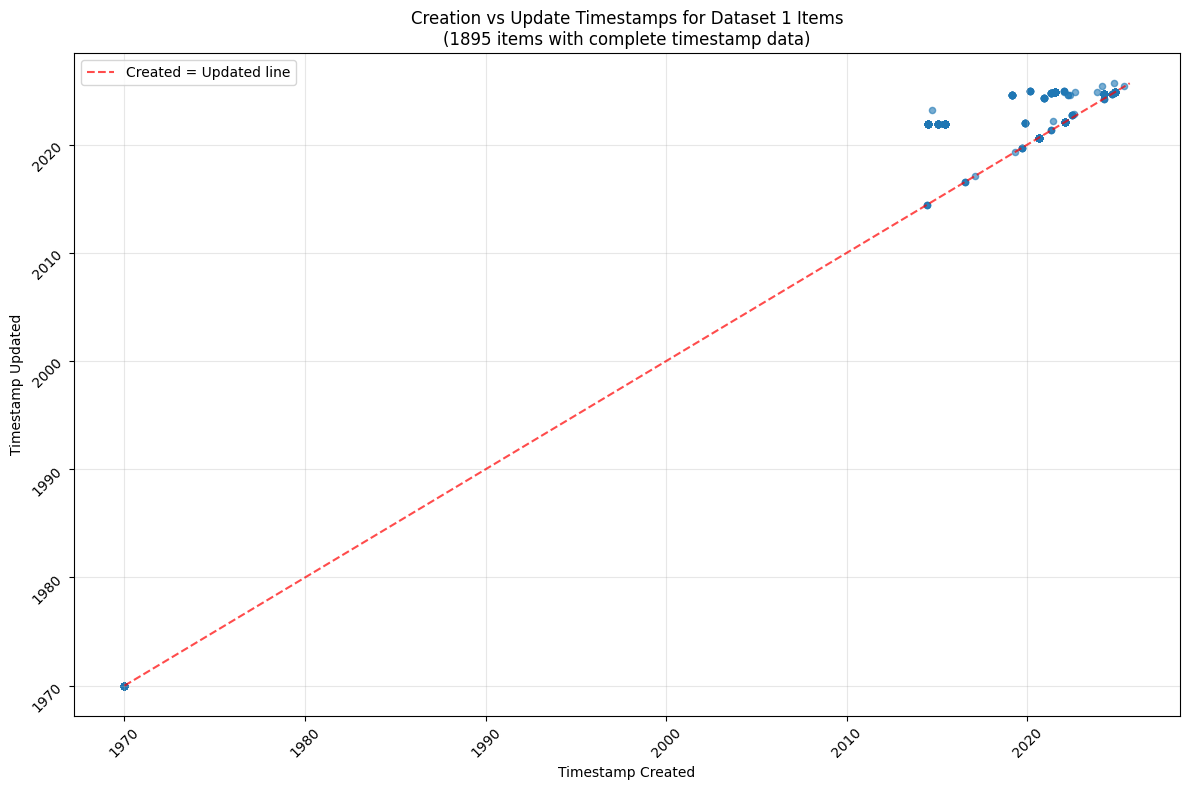


=== DATASET 1 ANALYSIS ===
Items with identical creation and update timestamps: 1396
Percentage of items never updated: 73.7%

Time Range Analysis:
Earliest creation date: 1970-01-01 00:00:00+00:00
Latest creation date: 2025-05-15 13:11:46.969000+00:00
Earliest update date: 1970-01-01 00:00:00+00:00
Latest update date: 2025-09-01 09:10:00.842000+00:00

TEMPORAL ANALYSIS - DATASET 1

Update Time Analysis (for 499 updated items):
  Average time to update: 1531.1 days (4.2 years)
  Median time to update:  1217.3 days (3.3 years)
  Fastest update:         1.3 days
  Slowest update:         3082.0 days (8.4 years)
  Standard deviation:     821.3 days

Item Age Analysis (creation to present):
  Average age of items:   2393.6 days (6.6 years)
  Median age of items:    1838.6 days (5.0 years)
  Newest item:            113.4 days old
  Oldest item:            20337.0 days old (55.7 years)
  Standard deviation:     3136.8 days (8.6 years)

INSIGHTS - DATASET 1
• 73.7% of items have never been u

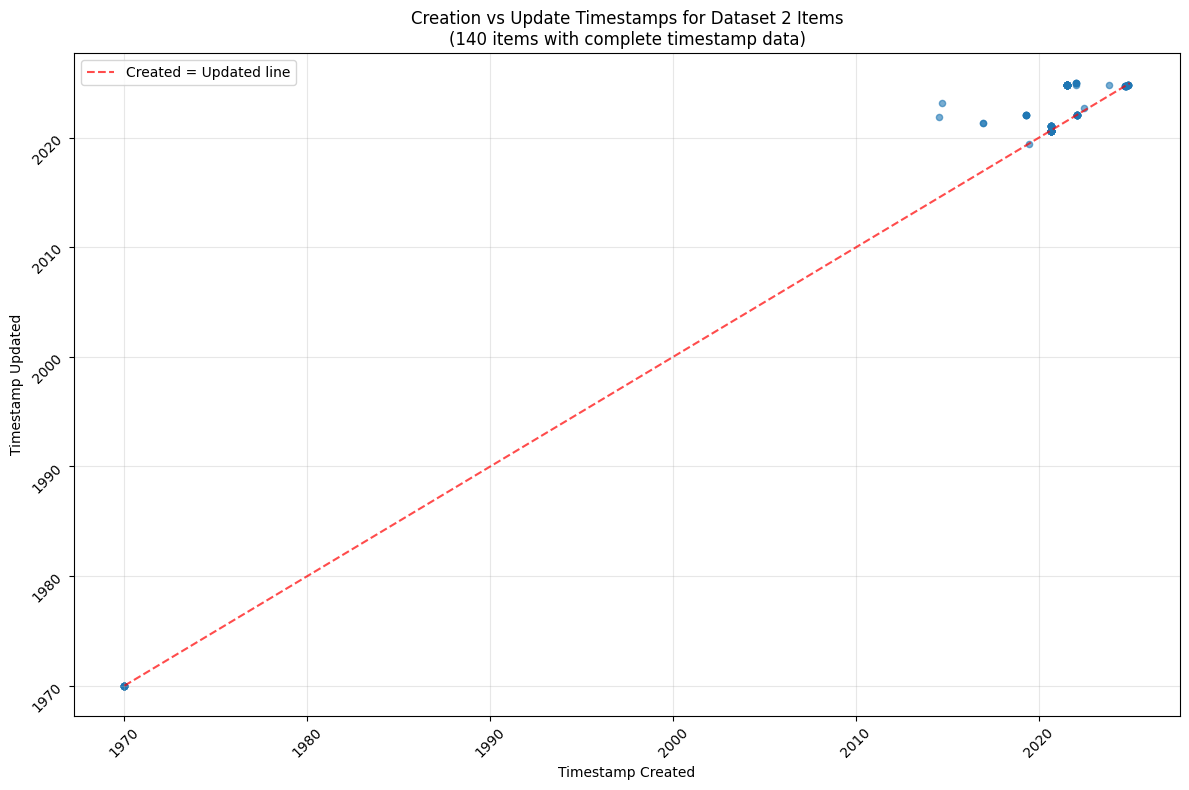


=== DATASET 2 ANALYSIS ===
Items with identical creation and update timestamps: 81
Percentage of items never updated: 57.9%

Time Range Analysis:
Earliest creation date: 1970-01-01 00:00:00+00:00
Latest creation date: 2024-11-05 12:42:54.949000+00:00
Earliest update date: 1970-01-01 00:00:00+00:00
Latest update date: 2024-12-17 15:17:54.003000+00:00

TEMPORAL ANALYSIS - DATASET 2

Update Time Analysis (for 59 updated items):
  Average time to update: 987.1 days (2.7 years)
  Median time to update:  1217.3 days (3.3 years)
  Fastest update:         105.3 days
  Slowest update:         3082.0 days (8.4 years)
  Standard deviation:     582.7 days

Item Age Analysis (creation to present):
  Average age of items:   3410.5 days (9.3 years)
  Median age of items:    1830.5 days (5.0 years)
  Newest item:            304.4 days old
  Oldest item:            20337.0 days old (55.7 years)
  Standard deviation:     5677.1 days (15.5 years)

INSIGHTS - DATASET 2
• 57.9% of items have never been up

In [24]:
# Run analysis for Dataset 1
print("=" * 60)
print("DATASET 1 ANALYSIS")
print("=" * 60)

created_1, updated_1 = extract_timestamps(results_1)
create_timestamp_plot(created_1, updated_1, "Dataset 1")
perform_temporal_analysis(created_1, updated_1, "Dataset 1")

print("\n" + "=" * 60)
print("DATASET 2 ANALYSIS")
print("=" * 60)

# Run analysis for Dataset 2
created_2, updated_2 = extract_timestamps(results_2)
create_timestamp_plot(created_2, updated_2, "Dataset 2")
perform_temporal_analysis(created_2, updated_2, "Dataset 2")

# Summary comparison
print("\n" + "=" * 60)
print("COMPARATIVE SUMMARY")
print("=" * 60)

if created_1 and created_2:
    never_updated_1 = sum(1 for c, u in zip(created_1, updated_1) if c == u)
    never_updated_2 = sum(1 for c, u in zip(created_2, updated_2) if c == u)

    never_pct_1 = never_updated_1 / len(created_1) * 100
    never_pct_2 = never_updated_2 / len(created_2) * 100

    print(f"Dataset 1: {len(results_1)} items found, {len(created_1)} with timestamps")
    print(f"Dataset 2: {len(results_2)} items found, {len(created_2)} with timestamps")
    print(f"\nNever updated comparison:")
    print(f"• Dataset 1: {never_pct_1:.1f}% of items never updated")
    print(f"• Dataset 2: {never_pct_2:.1f}% of items never updated")

    if never_pct_1 > never_pct_2:
        diff = never_pct_1 - never_pct_2
        print(
            f"• Dataset 1 has {diff:.1f} percentage points more items that were never updated"
        )
    elif never_pct_2 > never_pct_1:
        diff = never_pct_2 - never_pct_1
        print(
            f"• Dataset 2 has {diff:.1f} percentage points more items that were never updated"
        )
    else:
        print(f"• Both datasets have similar rates of items never updated")

In [ ]:
# Free up memory
del results_1
del results_2
gc.collect()